In [1]:
import numpy as np
from matplotlib import pyplot as plt

from scipy import stats as sps

In [2]:
from montecarlo import *
from montecarlo_onestep import *

from sabr_approx import *

In [3]:
Npaths = 100000
Nt = 100

In [48]:
F0 = 5

beta = 0.4

rho = -0.3

r = 0.0

T = 5

alpha= 0.3
sig0 = 0.5

tn = T * np.linspace(0, 1, Nt + 1)

In [49]:
F_bess_1 = SabrBessel(F0, sig0, Npaths, tn, alpha, beta, rho)
F_euler = SabrEuler(F0, sig0, Npaths, tn, alpha, beta, rho)
F_euler_mod = SabrEulerModified(F0, sig0, Npaths, tn, alpha, beta, rho)
F_direct = SabrDirectInversionScheme(F0, sig0, Npaths, [0, T/2, T], alpha, beta, rho)

In [50]:
Fs = [F_bess_1, F_euler, F_euler_mod, F_direct]
names = ["besel1", "euler", "eulerm", "direct"]

for name, F in zip(names, Fs):
    q75 = np.quantile(F, 0.75)
    pzero = sum(F == 0.0) / Npaths * 100
    print(f'{name},\t mean = {np.mean(F):4f} \t max = {np.max(F):4f}, \t q75 = {q75:4f}, \t p = {pzero:4f}%')
    

besel1,	 mean = 5.008737 	 max = 34.129857, 	 q75 = 6.337470, 	 p = 0.582000%
euler,	 mean = 5.001102 	 max = 31.925368, 	 q75 = 6.331224, 	 p = 2.244000%
eulerm,	 mean = 5.002460 	 max = 27.755662, 	 q75 = 6.325278, 	 p = 2.113000%
direct,	 mean = 5.424093 	 max = 33.330807, 	 q75 = 6.709156, 	 p = 1.336000%


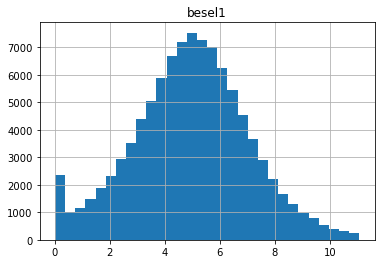

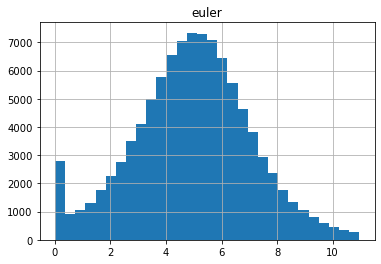

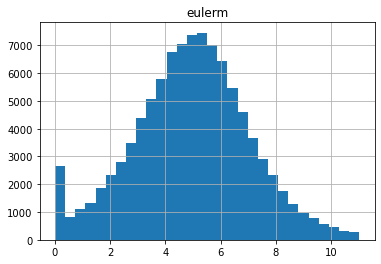

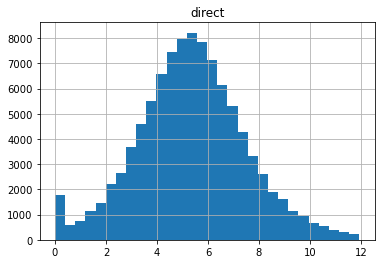

In [51]:
for name, F in zip(names, Fs):
    plt.figure()
    q = np.quantile(F, 0.99)
    plt.hist(F[F < q], bins=30)
    plt.grid()
    plt.title(name)
None

In [52]:
K = np.linspace(0.1 * F0, 3.0 * F0, 31)

In [53]:
Cpetr, ivpetr = SabrApprox(K, F0, r, T, sig0, alpha, beta, rho)

In [54]:
ivs = {}
Cs = {}
for name, F in zip(names, Fs):
    F_ = (F - np.mean(F)) + F0
    payoff = np.maximum(F_.reshape(-1, 1) - K.reshape(1, -1), 0.0)
    Cs[name] = np.mean(payoff, axis=0)
    ivs[name] = GetIv(Cs[name], K, F0, r, T)

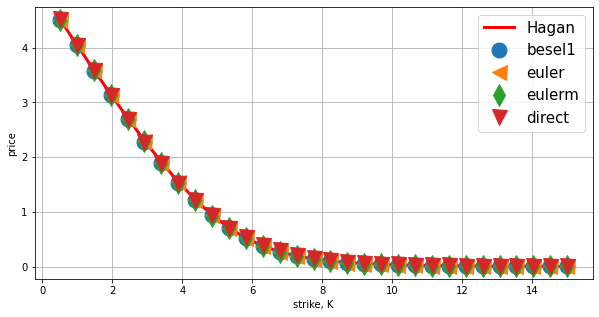

In [55]:
plt.figure(figsize=(10, 5))
plt.plot(K, Cpetr, '-r', linewidth=3.0, label='Hagan')
markers = ['o', '<', 'd', 'v']
i = 0
for name, C in Cs.items():
    plt.plot(K, C, markers[i], markersize=15, label=name)
    i += 1
plt.legend(fontsize=15)
plt.xlabel("strike, K")
plt.ylabel("price")
plt.grid()
None

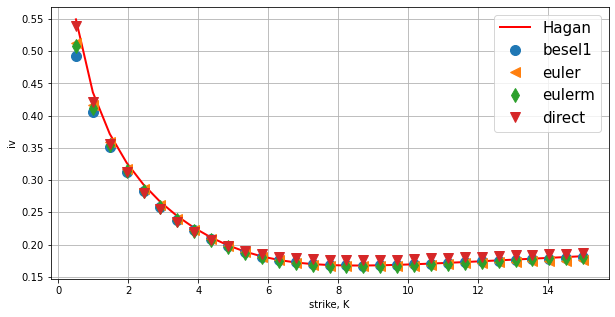

In [58]:
plt.figure(figsize=(10, 5))
plt.plot(K, ivpetr, '-r', linewidth=2.0, label='Hagan')
markers = ['o', '<', 'd', 'v']
i = 0
for name, iv in ivs.items():
    plt.plot(K, iv, markers[i], markersize=10, label=name)
    i += 1
plt.legend(fontsize=15)
plt.xlabel("strike, K")
plt.ylabel("iv")
plt.grid()
None

In [59]:
Cs['direct']

array([4.51780391, 4.04937641, 3.58761819, 3.13565496, 2.6979255 ,
       2.27977338, 1.88813119, 1.52969164, 1.21163394, 0.93898955,
       0.71431064, 0.53564743, 0.39785008, 0.29403711, 0.21758692,
       0.16172644, 0.12097819, 0.09102236, 0.0690852 , 0.05295356,
       0.04095543, 0.03205111, 0.02528128, 0.02008262, 0.01605629,
       0.01293974, 0.01043197, 0.00846784, 0.00691573, 0.00566932,
       0.00467863])

In [60]:
np.sort(F_direct)

array([ 0.        ,  0.        ,  0.        , ..., 29.06320876,
       31.88584256, 33.33080722])

In [61]:
np.sort(F_euler)

array([ 0.        ,  0.        ,  0.        , ..., 22.26547845,
       24.62120235, 31.92536839])

In [62]:
np.sort(F_euler_mod)

array([ 0.        ,  0.        ,  0.        , ..., 26.97347327,
       27.17002985, 27.75566195])